In [22]:
import xarray as xr
import numpy as np
!pip install geopy
!pip install huggingface_hub
from geopy.geocoders import Nominatim
from huggingface_hub import hf_hub_download
import re
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import os
import requests

In [23]:
def download_data(url, mode):
    if mode == 'train':
        data_folder = "../data/e3sm_train/"
    else:
        data_folder = "../data/e3sm_valid/"

    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    
    if os.path.exists(data_folder + os.path.basename(url)):
        print(f"File already exists in {data_folder}. Skipping download.")

    else:
        file_name = os.path.join(data_folder, url.split("/")[-1])
            
        response = requests.get(url)
        
        if response.status_code == 200:
            # file_name = url.split("/")[-1]
            with open(file_name, "wb") as file:
                file.write(response.content)
            print(f"File downloaded and saved to {file_name}")
        else:
            print("Failed to download the file.")

In [24]:
def get_data(training_period, validation_period):
    data_base_url = "https://huggingface.co/datasets/LEAP/ClimSim_low-res/tree/main/train"

    mode = 'train'
    response = requests.get(data_base_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        folder_links = soup.find_all('a', class_="col-span-8 flex items-center hover:underline md:col-span-4 lg:col-span-3")

        for link in folder_links:
            href = link.get('href')
            if href[-7:] in validation_period:
                mode = 'valid'
            if href.startswith('/datasets/LEAP/ClimSim_low-res/tree/main/train/') and re.match(r'/datasets/LEAP/ClimSim_low-res/tree/main/train/\d{4}-\d{2}', href):
                subfolder_url = urljoin(data_base_url, href)
                if href[-7:] in training_period or href[-7:] in validation_period: 
                    response_sub = requests.get(subfolder_url)
                    if response_sub.status_code == 200:
                            soup_sub = BeautifulSoup(response_sub.text, 'html.parser')
                            file_links = soup_sub.find_all('a', class_="group flex items-center truncate")
                            for file_link in file_links:
                                href_sub = file_link.get('href')
                                if re.match(r'/datasets/LEAP/ClimSim_low-res/blob/main/train/(\d{4}-\d{2}/[^\s]+)', href_sub):
                                    subfile_url = urljoin(subfolder_url, href_sub)
                                    download_data(subfile_url, mode)

    else:
        print("Failed to fetch the page.")


In [25]:
# Regular Expression Output Function

# Users input a start year-month and end year-month. The function then produces a list regular expressions
# (in the format used in the preprocessing notebook) that can be used to extract files within a particular date range.

def generate_file_regex(start_year_month, end_year_month):
    # Split the start and end year-month strings into integers for processing.
    start_year, start_month = map(int, start_year_month.split('-'))
    end_year, end_month = map(int, end_year_month.split('-'))
    
    # Initialize an empty list to store the generated regular expressions.
    regexps = []

    # Iterate through the years from the start year to the end year (inclusive).
    for year in range(start_year, end_year + 1):
        # Format the year as a 4-digit string, padding with zeros if necessary.
        year_str = str(year).zfill(4)

        # Determine the range of months to consider based on the current year.
        if year == start_year and year == end_year:
            month_range = range(start_month, end_month + 1)
        elif year == start_year:
            month_range = range(start_month, 13)
        elif year == end_year:
            month_range = range(1, end_month + 1)
        else:
            month_range = range(1, 13)

        # Create a pattern for the months within the year, separated by the "|" symbol.
        month_pattern = "|".join([str(month).zfill(2) for month in month_range])

        # Construct the regular expression using the year and the month pattern.
        regex = f'E3SM-MMF.mli.{year_str}-({month_pattern})-*-*.nc'

        # Add the generated regular expression to the list.
        regexps.append(regex)

    # Return the list of generated regular expressions.
    return regexps

In [26]:
# Function to allow user input of geographic and temporal data

# Setting locations to "all" does not filter the data by location

def climsim_geo_temporal_data_finder(locations, training_period, validation_period):
    # Function to coerce location names into latitude and longitude
    def coerce_to_lat_lon(location):
        geolocator = Nominatim(user_agent="geo_locator")
        location_info = geolocator.geocode(location)
        if location_info is not None:
            return location_info.latitude, location_info.longitude
        else:
            return None

    # Download the NetCDF file using Hugging Face's function
    repo_id = "LEAP/ClimSim_low-res"  # Replace with the actual repository ID
    filename = "ClimSim_low-res_grid-info.nc"  # Replace with the actual filename
    local_filepath = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset")

    # Load the .nc file
    nc_data = xr.open_dataset(local_filepath)

    # Extract grid latitude and longitude values
    latitude = nc_data["lat"].values
    longitude = nc_data["lon"].values

    # Define a function to find the nearest point
    def find_nearest_lat_lon(user_lat, user_lon, latitude, longitude):
        lat_diff = latitude - user_lat
        lon_diff = longitude - user_lon
        distance = np.sqrt(lat_diff ** 2 + lon_diff ** 2)
        # Find the index of the minimum distance
        idx = np.unravel_index(np.argmin(distance), distance.shape)
        return idx

    # Function to classify user locations
    def classify_user_locations(user_locations, nc_data):
        column_numbers = []
        for user_location in user_locations:
            if isinstance(user_location, str):
                user_lat, user_lon = coerce_to_lat_lon(user_location)
                if user_lat is None or user_lon is None:
                    raise ValueError(f"Invalid coordinates for location: {user_location}")

            elif isinstance(user_location, tuple) and len(user_location) == 2:
                user_lat, user_lon = user_location
            else:
                raise ValueError("Invalid user location format")

            # Find the nearest latitude and longitude point
            idx = find_nearest_lat_lon(user_lat, user_lon, latitude, longitude)

            # Get the corresponding column number
            column_number = nc_data["ncol"][idx[0]].values
            column_numbers.append(column_number)

        return column_numbers

    # Call the classification function with user input locations
    if not locations or "all" in locations:
        all_column_numbers = nc_data["ncol"].values.tolist()
        return all_column_numbers, [], []  # No regex patterns for all data
    else:
        latitude_longitude_list = []

        for location in locations:
            if isinstance(location, (str, tuple)):
                latitude_longitude_list.append(location)
            else:
                raise ValueError("Invalid user location format")

        column_numbers = classify_user_locations(latitude_longitude_list, nc_data)

        unique_column_numbers = list(set(np.ravel(column_numbers)))

        # Use the generate_file_regex function to get date range regexes
        training_regexes = generate_file_regex(training_period[0], training_period[1])
        validation_regexes = generate_file_regex(validation_period[0], validation_period[1])

        return unique_column_numbers, training_regexes, validation_regexes

In [27]:
training_period = ("0001-06", "0004-06")
validation_period = ("0005-01", "0005-02")

get_data(training_period, validation_period)


File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping download.
File already exists in ../data/e3sm_train/. Skipping do

File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping download.
File already exists in ../data/e3sm_valid/. Skipping do

In [30]:
df = xrdataset.to_dataframe()['state_q0001']
df = pd.DataFrame(xrdataset.to_dataframe())
df
value_at_ncol_26 = df.xs(26, level='ncol')['state_q0001']

# Print the selected value
print(value_at_ncol_26)

NameError: name 'pd' is not defined

In [13]:
# Code Tester

# Locations include place names, coordinates, duplicates, and closeby cities
locations = ["New York, USA", "Tokyo", "Detroit, MI", "Havana, Cuba", (40.7128, -74.0060), (35.682839, 139.759455), (34.0522, -118.2437), (51.5074, -0.1278), "Manaus, Brazil"]

training_period = ("0001-06", "0004-06")
validation_period = ("0008-01", "0009-06")
result = climsim_geo_temporal_data_finder(locations, training_period, validation_period)
result

IndexError: index 0 is out of bounds for axis 0 with size 0

In [97]:
dir = "C:/Users/lia/Downloads/ClimSim_data"
import glob

# Replace '/path/to/directory' with the path of the directory you want to list files in
file_list = glob.glob(f"{dir}/*")

for file in file_list:
    print(file)
xrdataset = xr.open_dataset(file_list[0])

C:/Users/lia/Downloads/ClimSim_data\E3SM-MMF.mli.0001-02-01-00000.nc
C:/Users/lia/Downloads/ClimSim_data\E3SM-MMF.mli.0001-02-01-01200.nc
C:/Users/lia/Downloads/ClimSim_data\E3SM-MMF.mli.0001-02-01-02400.nc
C:/Users/lia/Downloads/ClimSim_data\E3SM-MMF.mli.0001-02-01-03600.nc


In [98]:
!pip install netCDF4

In [99]:
import netCDF4 as nc

# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-00000.nc"
dataset1 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_q0001"
data1 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-01200.nc"
dataset2 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_q0001"
data2 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-02400.nc"
dataset3 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_q0001"
data3 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-03600.nc"
dataset4 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_q0001"
data4 = dataset.variables[variable_name][:]  # This will return the entire variable's data

In [100]:
#Combining the datasets from different files
import numpy.ma as ma
dfh59 = ma.concatenate([data1[59], data2[59], data3[59], data4[59]])
dfh0 = ma.concatenate([data1[0], data2[0], data3[0], data4[0]])
len(dfh59)

1536

In [24]:
!pip install matplotlib

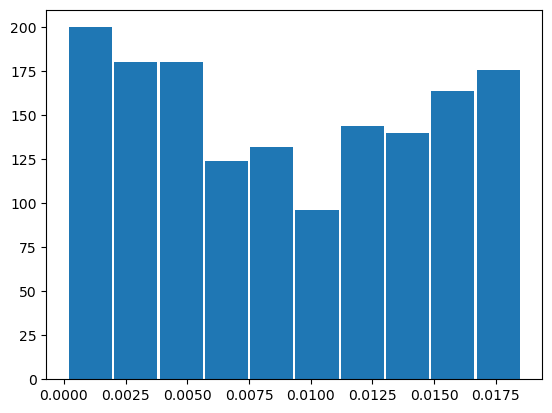

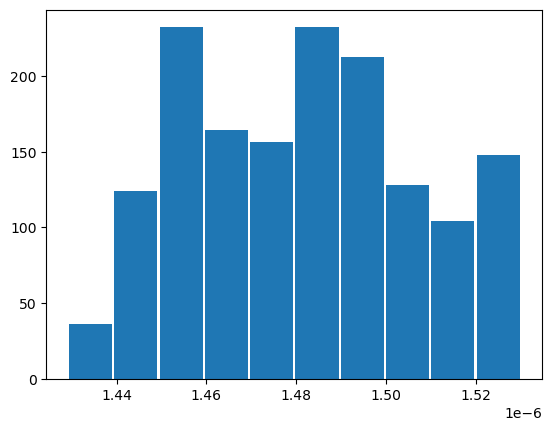

In [101]:
import matplotlib.pyplot as plt

plt.hist(dfh59, rwidth=0.95)
plt.show()

plt.hist(dfh0, rwidth=0.95)
plt.show()

In [102]:
import netCDF4 as nc

# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-00000.nc"
dataset1 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_t"
data1 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-01200.nc"
dataset2 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_t"
data2 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-02400.nc"
dataset3 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_t"
data3 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-03600.nc"
dataset4 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_t"
data4 = dataset.variables[variable_name][:]  # This will return the entire variable's data

In [103]:
#Combining the datasets from different files
import numpy.ma as ma
dft59 = ma.concatenate([data1[59], data2[59], data3[59], data4[59]])
dft0 = ma.concatenate([data1[0], data2[0], data3[0], data4[0]])
len(dfh59)

1536

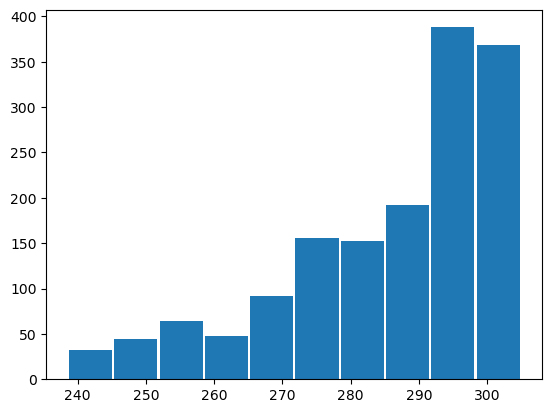

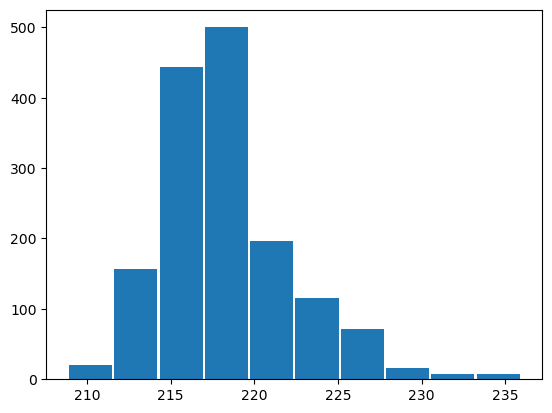

In [104]:
import matplotlib.pyplot as plt

plt.hist(dft59, rwidth=0.95)
plt.show()

plt.hist(dft0, rwidth=0.95)
plt.show()

In [108]:
import netCDF4 as nc

# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-00000.nc"
dataset1 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "pbuf_SOLIN"
data1 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-01200.nc"
dataset2 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "pbuf_SOLIN"
data2 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-02400.nc"
dataset3 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "pbuf_SOLIN"
data3 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-03600.nc"
dataset4 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "pbuf_SOLIN"
data4 = dataset.variables[variable_name][:]  # This will return the entire variable's data

In [113]:
#Combining the datasets from different files
dfr59 = ma.concatenate([data1, data2, data3, data4])
len(dfr59)

1536

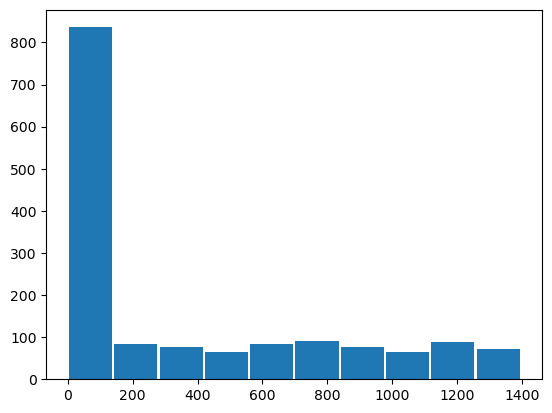

In [115]:
import matplotlib.pyplot as plt

plt.hist(dfr59, rwidth=0.95)
plt.show()


In [116]:
import netCDF4 as nc

# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-00000.nc"
dataset1 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_ps"
data1 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-01200.nc"
dataset2 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_ps"
data2 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-02400.nc"
dataset3 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_ps"
data3 = dataset.variables[variable_name][:]  # This will return the entire variable's data

#Replicated for other files
# Open the NetCDF file
file_path = "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-03600.nc"
dataset4 = nc.Dataset(file_path, "r")  # "r" stands for read mode

# Access dimensions
dimensions = dataset.dimensions

# Access variables
variables = dataset.variables

# Read data from a variable
variable_name = "state_ps"
data4 = dataset.variables[variable_name][:]  # This will return the entire variable's data

In [117]:
#Combining the datasets from different files
dfp59 = ma.concatenate([data1, data2, data3, data4])
len(dfp59)

1536

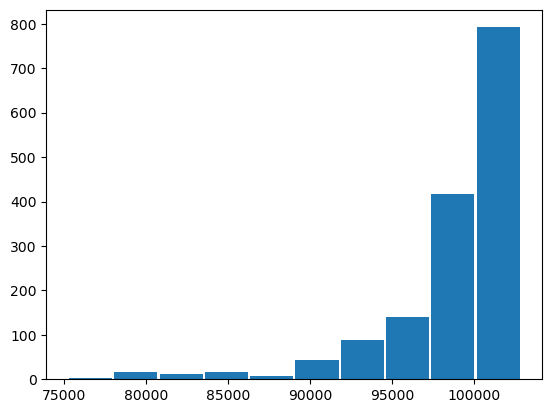

In [118]:
import matplotlib.pyplot as plt

plt.hist(dfp59, rwidth=0.95)
plt.show()


In [48]:
import netCDF4 as nc

# List of file paths to the NetCDF files you want to combine
file_paths = ["C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-00000.nc"
              , "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-01200.nc"
              , "C:/Users/lia/Downloads/ClimSim_data/E3SM-MMF.mli.0001-02-01-02400.nc"]



# Loop through the list of file paths
for file_path in file_paths:
    # Open each NetCDF file for reading
    dataset = nc.Dataset(file_path, "r")  # "r" stands for read mode
    
    # Loop through variables in the current dataset and add them to the combined dataset
    for var_name in dataset.variables:
        variable = dataset.variables[var_name]
        

In [50]:
len(dataset[1])

TypeError: expected str, bytes or os.PathLike object, not int

In [46]:
import matplotlib.pyplot as plt

plt.hist(combined_dataset[59])
plt.show()

plt.hist(combined_dataset[0])
plt.show()

TypeError: expected str, bytes or os.PathLike object, not int

In [10]:
for var_name in dataset.variables:
    variable = dataset.variables[var_name]
    
    # Check if the variable has more than 5 rows of data
    if len(variable.shape) == 1:
        # For 1D variables
        data = variable[:]
    else:
        # For 2D or higher-dimensional variables, you can slice the first 5 rows
        data = variable[:5, ...]  # Slice the first 5 rows along the first dimension
    
    print(f"Variable: {var_name}")
    print(data)
    print("\n")

Variable: ymd
10201


Variable: tod
0


Variable: cam_in_ALDIF
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.06       0.06       1.         0.06
 0.06       0.06       0.06       0.06       0.10857851 0.14740287
 0.20736593 0.26316729 1.         1.         1.         1.
 1.         0.06       1.         0.06       0.06       0.06
 0.06123205 0.10937438 0.06925917 0.1457